In [1]:
import os
import re
import copy
import numpy
from IPython.display import Image, display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.data.rmg import RMGDatabase
from rmgpy import settings
from rmgpy.species import Species
from rmgpy.molecule import Molecule
from rmgpy.cantherm.output import prettify

In [14]:
def addThermoData(thermoData1, thermoData2):
    """
    Add the thermodynamic data `thermoData2` to the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] += thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si += thermoData2.H298.value_si
    thermoData1.S298.value_si += thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def removeThermoData(thermoData1, thermoData2):
    """
    Remove the thermodynamic data `thermoData2` from the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] -= thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si -= thermoData2.H298.value_si
    thermoData1.S298.value_si -= thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def averageThermoData(thermoDataset=[]):
    """
    Average a list of thermoData values together.
    Sets uncertainty values to be the approximately the 95% confidence interval, equivalent to
    2 standard deviations calculated using the sample standard variance:
    
    Uncertainty = 2s
    s = sqrt( sum(abs(x - x.mean())^2) / N - 1) where N is the number of values averaged
    
    Note that uncertainties are only computed when number of values is greater than 1.
    """
    
    numValues = len(thermoDataset)
        
    if numValues == 0:
        raise Exception('No thermo data values were inputted to be averaged.')
    else:
        print 'Averaging thermo data over {0} value(s).'.format(numValues)
        
        if numValues == 1:
            return copy.deepcopy(thermoDataset[0])
        
        else:
            averagedThermoData = copy.deepcopy(thermoDataset[0])
            for thermoData in thermoDataset[1:]:
                averagedThermoData = addThermoData(averagedThermoData, thermoData)


            for i in range(averagedThermoData.Tdata.value_si.shape[0]):
                averagedThermoData.Cpdata.value_si[i] /= numValues
                #print averagedThermoData.Cpdata.uncertainty
                cpData = [thermoData.Cpdata.value_si[i] for thermoData in thermoDataset]
                averagedThermoData.Cpdata.uncertainty[i] = 2*numpy.std(cpData, ddof=1)

            HData = [thermoData.H298.value_si for themoData in thermoDataset]
            averagedThermoData.H298.value_si /= numValues
            #print averagedThermoData.H298.getUncertainty()
            #print averagedThermoData.H298.uncertainty
            #print averagedThermoData.H298.uncertainty_si
            averagedThermoData.H298.uncertainty_si = 2*numpy.std(HData, ddof=1)

            SData = [thermoData.S298.value_si for themoData in thermoDataset]
            averagedThermoData.S298.value_si /= numValues
            averagedThermoData.S298.uncertainty_si = 2*numpy.std(SData, ddof=1)
            return averagedThermoData
        
def isolateCyclicGroups(molecule):
    """
    Isolates the cyclic groups within a saturated molecule and create a new Group object for each cycle
    """
    from rmgpy.molecule.group import Group
    
    molecule.deleteHydrogens()
    SSSR = molecule.getSmallestSetOfSmallestRings()
    
    groups = []
    for cycle in SSSR:
        print cycle
        print cycle[0]
        groups.append(Group(atoms=cycle))
        

In [3]:
# Fill in the list of thermo libraries to be used for fitting polycyclic thermo groups
thermoLibraries = ['C10H11']
database = RMGDatabase()
database.load(settings['database.directory'], thermoLibraries = thermoLibraries, kineticsFamilies='none', kineticsDepositories='none', reactionLibraries=[])

thermoDatabase = database.thermo

In [4]:
fittingDictionary={}
for libraryName in thermoLibraries:
    thermoLibrary = database.thermo.libraries[libraryName]

Species pdt7 has a single polycyclic group match in thermo estimate: PolycyclicRing


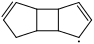

Original polycyclic group was generic, must create new polycyclic group...
Species pdt8 has a single polycyclic group match in thermo estimate: PolycyclicRing


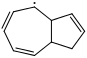

Original polycyclic group was generic, must create new polycyclic group...
Species pdt10bis has a single polycyclic group match in thermo estimate: PolycyclicRing


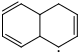

Original polycyclic group was generic, must create new polycyclic group...
Species pdt11 has a single polycyclic group match in thermo estimate: PolycyclicRing


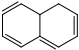

Original polycyclic group was generic, must create new polycyclic group...
Species pdt17 has a single polycyclic group match in thermo estimate: PolycyclicRing


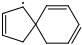

Original polycyclic group was generic, must create new polycyclic group...
Species pdt19 has a single polycyclic group match in thermo estimate: PolycyclicRing


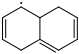

Original polycyclic group was generic, must create new polycyclic group...
Species pdt21 has a single polycyclic group match in thermo estimate: PolycyclicRing


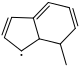

Original polycyclic group was generic, must create new polycyclic group...
Species pdt22 has a single polycyclic group match in thermo estimate: PolycyclicRing


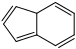

Original polycyclic group was generic, must create new polycyclic group...
Species pdt23 has a single polycyclic group match in thermo estimate: PolycyclicRing


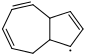

Original polycyclic group was generic, must create new polycyclic group...
Species pdt24 has a single polycyclic group match in thermo estimate: PolycyclicRing


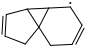

Original polycyclic group was generic, must create new polycyclic group...
Species pdt26 has a single polycyclic group match in thermo estimate: PolycyclicRing


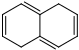

Original polycyclic group was generic, must create new polycyclic group...
Species pdt27 has a single polycyclic group match in thermo estimate: PolycyclicRing


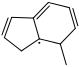

Original polycyclic group was generic, must create new polycyclic group...
Species pdt28 has a single polycyclic group match in thermo estimate: PolycyclicRing


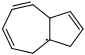

Original polycyclic group was generic, must create new polycyclic group...
Species pdt29 has a single polycyclic group match in thermo estimate: PolycyclicRing


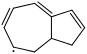

Original polycyclic group was generic, must create new polycyclic group...
Species pdt30 has a single polycyclic group match in thermo estimate: PolycyclicRing


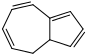

Original polycyclic group was generic, must create new polycyclic group...
Species pdt31 has a single polycyclic group match in thermo estimate: PolycyclicRing


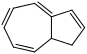

Original polycyclic group was generic, must create new polycyclic group...
Species pdt32 has a single polycyclic group match in thermo estimate: PolycyclicRing


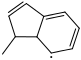

Original polycyclic group was generic, must create new polycyclic group...
Species pdt35 has a single polycyclic group match in thermo estimate: PolycyclicRing


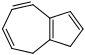

Original polycyclic group was generic, must create new polycyclic group...
Species pdt37 has a single polycyclic group match in thermo estimate: PolycyclicRing


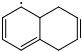

Original polycyclic group was generic, must create new polycyclic group...
Species pdt38 has a single polycyclic group match in thermo estimate: PolycyclicRing


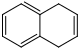

Original polycyclic group was generic, must create new polycyclic group...
Species INDENE has a single polycyclic group match in thermo estimate: indene


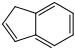

Species pdt57 has a single polycyclic group match in thermo estimate: PolycyclicRing


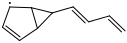

Original polycyclic group was generic, must create new polycyclic group...
Species 2HINDENE has a single polycyclic group match in thermo estimate: PolycyclicRing


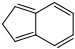

Original polycyclic group was generic, must create new polycyclic group...


In [17]:
for label, entry in thermoLibrary.entries.iteritems():
    molecule = entry.item
    libraryThermoData = entry.data
    if molecule.getAllPolycyclicVertices():
        species = Species(molecule=[molecule])
        species.generateResonanceIsomers() 
        estimatedThermo = thermoDatabase.getThermoDataFromGroups(species)
        
        tokens = estimatedThermo.comment.split()
        polycyclicGroups = []
        for token in tokens:
            if 'polycyclic' in token:
                splitTokens = re.split("\(|\)",token)
                assert len(splitTokens) == 3
                groupLabel = splitTokens[1]
                polycyclicGroups.append(thermoDatabase.groups['polycyclic'].entries[groupLabel])

        if len(polycyclicGroups) == 0:
            print 'Species {0} detected as polycyclic but estimated thermo contained no polycyclic groups: \
                    you need to create a new polycyclic group'.format(label)
            
        elif len(polycyclicGroups) == 1:
            polycyclicGroup = polycyclicGroups[0]
            print 'Species {0} has a single polycyclic group match in thermo estimate: {1}'.format(label, polycyclicGroup.label)
            # Draw the molecule in ipython notebook
            display(molecule)
            
            withoutPolycyclicGroupThermo = removeThermoData(estimatedThermo, polycyclicGroup.data)
            newPolycyclicGroupThermo = removeThermoData(libraryThermoData, withoutPolycyclicGroupThermo)
            # At this point the estimatedThermo and librarythermoData are permanently modified and should not be reused
            
            
            # Check to make sure that the polycyclic group is not generic
            if polycyclicGroup.label == 'PolycyclicRing':
                print 'Original polycyclic group was generic, must create new polycyclic group...'
                struct = molecule.copy(deep=True)
                # Saturate the structure if it is a radical
                if struct.isRadical():
                    struct.saturate()
               # newGroups = isolateCyclicGroups(molecule)
                #print len(newGroups)
                #print newGroup[0].toAdjacencyList()
                
            
            
            
            
            
            # Add the new group value to the fitting dictionary
            if polycyclicGroup not in fittingDictionary:
                # Add a tuple containing fitted group data, the original library entry, and thermo library
                fittingDictionary[polycyclicGroup]=[(newPolycyclicGroupThermo, entry, thermoLibrary)]
            else:
                fittingDictionary[polycyclicGroup].append((newPolycyclicGroupThermo, entry, thermoLibrary))
                
        elif len(polycyclicGroups) > 1:
            print 'Species {0} has matched multiple polycyclic groups. \
                    This cannot be fitted with a single molecule\'s thermo data.'.format(label)


In [6]:
molecule.isRadical(), "Method only valid for radicals."
        saturatedStruct = molecule.copy(deep=True)
        added = saturatedStruct.saturate()for polycyclicGroup, fittingGroups in fittingDictionary.iteritems():
    print 'Original thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    print prettify(repr(polycyclicGroup.data))
    
    thermoDataset = [fitTuple[0] for fitTuple in fittingGroups]
    labels = [fitTuple[1].label for fitTuple in fittingGroups]
    libraryLabels = [fitTuple[2].name for fitTuple in fittingGroups]
    # Average the new group values to fit the original polycyclic group
    fittedGroupData = averageThermoData([fitTuple[0] for fitTuple in fittingGroups])
    #print fittedGroupData
    #print fittingGroups
    polycyclicGroup.data = fittedGroupData
    polycyclicGroup.shortDesc = "Fitted from thermo library values"
    
    comment = ''
    for i in range(len(labels)):
        comment += "Fitted from {0} species from {1} library.\n".format(labels[i],libraryLabels[i])
    polycyclicGroup.longDesc = comment.strip()
    
    print 'Fitted thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    print prettify(repr(polycyclicGroup.data))
    print polycyclicGroup.longDesc
    print '===================================================================='
    # At this point, save and overwrite the entire polycyclic thermo library

Original thermo data for polycyclic group: PolycyclicRing
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(PolycyclicRing)',
)
Averaging thermo data over 22 value(s).
Fitted thermo data for polycyclic group: PolycyclicRing
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([-7.35182, -7.40909, -6.95227, -6.14864, -5.03182, -4.12318, -2.90273], 'cal/(mol*K)', '+|-', [18.9537, 19.6523, 18.2452, 15.7002, 11.4143, 9.04092, 7.72542]),
    H298 = (12.6705, 'kcal/mol'),
    S298 = (57.9854, 'cal/(mol*K)', '+|-', 4.17168e-14),
)
Fitted from pdt7 species from C10H11 library.
Fitted from pdt8 species from C10H11 library.
Fitted from pdt10bis species from C10H11 library.
Fitted from pdt11 species from C10H11 library.
Fitted from pdt17 species from C10H11 library.
Fitted from pdt19 species from C10H11 library

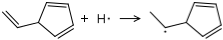

In [7]:
from rmgpy.reaction import *
from rmgpy.kinetics import *
rxn = Reaction(index=1, reactants=[Species(label="", molecule=[Molecule(SMILES="C=CC1C=CC=C1")]), 
                                   Species(label="", molecule=[Molecule(SMILES="[H]")])], 
               products=[Species(label="", molecule=[Molecule(SMILES="C[CH]C1C=CC=C1")])], 
               kinetics=Arrhenius(A=(3.36e+08,'cm^3/(mol*s)'), n=1.56, Ea=(0.6,'kcal/mol'), T0=(1,'K')))
display(rxn)
